## One-Dimensional Steady Flow with Transport

phreeqc ex11



### One-Dimensional Steady Flow with Transport Problem Setup

Imports

In [1]:
import os
import sys

In [2]:
import flopy
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import modflowapi
from modflowapi import Callbacks
from pathlib import Path

In [4]:
import phreeqcrm
##from phreeqcrm import BMIPhreeqcRM
##import phreeqcrm as rm
##import phreeqcrm as phrqcrm
import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
import shutil

Append to system path to include the common subdirectory

In [5]:
sys.path.append(os.path.join("..", "common"))

Import common functionality

In [6]:
import analytical
import config
from figspecs import USGSFigure

Set figure properties specific to this problem

In [7]:
figure_size = (5, 3)
#figure_size = None

Base simulation and model name and workspace

In [8]:
ws = config.base_ws
example_name = "moc"

In [9]:
from contextlib import contextmanager
@contextmanager
def change_directory(new_dir):
    original_dir = os.getcwd()  # Get the current working directory

    # Convert relative path to an absolute path
    new_dir = os.path.abspath(new_dir)
    
    # Check if the directory exists; if not, create it
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    try:
        os.chdir(new_dir)  # Change to the specified directory
        yield
    finally:
        os.chdir(original_dir)  # Change back to the original directory when done

Scenario parameters - make sure there is at least one blank line before next item

In [10]:
parameters = {
    "ex11-bmi-mmols-single": {
        "longitudinal_dispersivity": 0.002,
    },
}

Scenario parameter units - make sure there is at least one blank line before next item
add parameter_units to add units to the scenario parameter table

In [11]:
parameter_units = {
    "longitudinal_dispersivity": "$m$",
}

Model units

In [12]:
length_units = "METERS"    # m
time_units = "seconds"     # s

Table of model parameters

In [13]:
nper = 1                      # Number of periods
nlay = 1                      # Number of layers
nrow = 1                      # Number of rows
ncol = 40                     # Number of columns
system_length = .08           # Length of system ($m$)
delr = 0.002                  # Column width ($m$)
delc = 1.0                    # Row width ($m$)
top = 1.0                     # Top of the model ($m$)
botm = 0                      # Layer bottom elevation ($m$)
hydraulic_conductivity = 1.0  # Hydraulic conductivity ($m s^{-1}$)
porosity = 0.2                # Porosity of mobile domain (unitless)
specific_discharge = 1./720.*porosity  # Specific discharge ($m s^{-1}$)
total_time = 72000.0          # Simulation time ($s$)
concentration_factor = 1.     # Scale factor ($millmoles/mole$)


Create yaml for phreeqcrm initialize()

In [14]:
def setup_phreeqcrm(sim_folder):
    
    ##os.chdir(sys.path[0])
    notebook_directory = sys.path[0]    
    assert(os.getcwd() == notebook_directory)

    assert(sim_folder == "ex11-bmi-mmols-single")
    
    # get abspath before change_directory
    sim_ws = os.path.abspath(os.path.join(ws, sim_folder, "phreeqcrm"))

    with change_directory(sim_ws):
        
        # copy phreeqc.dat to sim_ws
        source_file = os.path.join(notebook_directory, 'phreeqc.dat')
        shutil.copy(source_file, sim_ws)

        # copy advect.pqi to sim_ws
        source_file = os.path.join(notebook_directory, 'advect.pqi')
        shutil.copy(source_file, sim_ws)
    
        # Create YAMLPhreeqcRM document
        yrm = phreeqcrm.YAMLPhreeqcRM()

        # Number of cells
        nxyz = nlay*nrow*ncol

        # Set GridCellCount
        yrm.YAMLSetGridCellCount(nxyz)

        # Set some properties
        yrm.YAMLSetErrorHandlerMode(1)
        yrm.YAMLSetComponentH2O(False)
        yrm.YAMLSetRebalanceFraction(0.5)
        yrm.YAMLSetRebalanceByCell(True)
        yrm.YAMLUseSolutionDensityVolume(False)
        yrm.YAMLSetPartitionUZSolids(False)

        # Set concentration units
        yrm.YAMLSetUnitsSolution(2)           # 1, mg/L; 2, mol/L; 3, kg/kgs
        yrm.YAMLSetUnitsPPassemblage(1)       # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsExchange(1)           # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsSurface(1)            # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsGasPhase(1)           # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsSSassemblage(1)       # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsKinetics(1)           # 0, mol/L cell; 1, mol/L water; 2 mol/L rock

        # Set conversion from seconds to user units (days) Only affects one print statement
        time_conversion = 1.0 / 86400.0
        yrm.YAMLSetTimeConversion(time_conversion)

        # Set representative volume
        rv = [1] * nxyz
        yrm.YAMLSetRepresentativeVolume(rv)

        # Set initial density
        density = [1.0] * nxyz
        yrm.YAMLSetDensityUser(density)

        # Set initial porosity
        por = [0.2] * nxyz
        yrm.YAMLSetPorosity(por)

        # Set initial saturation
        sat = [1] * nxyz
        yrm.YAMLSetSaturationUser(sat)

        # Load database
        yrm.YAMLLoadDatabase("phreeqc.dat")

        # Run file to define solutions and reactants for initial conditions, selected output
        workers = True             # Worker instances do the reaction calculations for transport
        initial_phreeqc = True     # InitialPhreeqc instance accumulates initial and boundary conditions
        utility = True             # Utility instance is available for processing
        yrm.YAMLRunFile(workers, initial_phreeqc, utility, "advect.pqi")

        # Clear contents of workers and utility
        initial_phreeqc = False
        input = "DELETE; -all"
        yrm.YAMLRunString(workers, initial_phreeqc, utility, input)
        yrm.YAMLAddOutputVars("AddOutputVars", "true")

        # Determine number of components to transport
        yrm.YAMLFindComponents()

        # initial solutions
        initial_solutions = [1] * nxyz
        yrm.YAMLInitialSolutions2Module(initial_solutions)

        # initial exchanges
        initial_exchanges = [1] * nxyz
        yrm.YAMLInitialExchanges2Module(initial_exchanges)

        # Write YAML file
        yrm.WriteYAMLDoc("ex11-advect.yaml")
        
    return "ex11-advect.yaml"

In [15]:
def build_phreeqcrm(sim_folder):
    yaml = setup_phreeqcrm(sim_folder)
    
    rm = None
    try:
        # get abspath before change_directory
        sim_ws = os.path.abspath(os.path.join(ws, sim_folder, "phreeqcrm"))
        
        rm = phreeqcrm.BMIPhreeqcRM()
        with change_directory(sim_ws):
            rm.initialize(yaml)
            
        rm.solutes = rm.get_value_ptr("Components")
        ncomps     = rm.get_value_ptr("ComponentCount")[0]

        nxyz = nlay*nrow*ncol
        assert nxyz == rm.get_value_ptr("GridCellCount")[0]        
        
        # Get initial concentrations
        rm.initial_solution = rm.get_value_ptr("Concentrations")[::nxyz]
        assert len(rm.initial_solution) == ncomps

        # Set boundary condition
        bc1 = [0]           # solution 0 from Initial IPhreeqc instance
        rm.influent_concentration = rm.InitialPhreeqc2Concentrations(bc1)

        # Convert to millimoles
        rm.initial_solution       = rm.initial_solution * concentration_factor
        rm.influent_concentration = rm.influent_concentration * concentration_factor
            
    except:
        raise RuntimeError("build_phreeqcrm failed")
    return rm

### Functions to build, write, run, and plot models

MODFLOW 6 flopy GWF simulation object (sim) is returned


In [16]:
def build_mf6gwfgwt(sim_folder, solutes, influent_concentration, initial_solution, longitudinal_dispersivity):
    name = "flow"
    sim_ws = os.path.join(ws, sim_folder, "mf6gwfgwt")
    sim = flopy.mf6.MFSimulation(
        sim_name=name, sim_ws=sim_ws, exe_name="mf6"
    )
    tdis_ds = ((total_time, 400, 1.0),)    
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    ims = flopy.mf6.ModflowIms(sim, filename=f"{name}.ims")
    
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    sim.register_ims_package(ims, [gwf.name])
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    wel_spd = {
        0: [
            [
                (0, 0, 0),
                specific_discharge * delc * delr,   # m^3/s
                *influent_concentration,
            ]
        ],
    }
    
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        pname="WEL-1",
        auxiliary=solutes.tolist()
    )
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    
    # set vars for use in run_model
    sim.sim_ws = sim_ws
    
    # @todo update for other OSs
    sim.libmf6 = Path(os.path.join(os.environ["USERPROFILE"], "AppData\\Local\\flopy\\bin", "libmf6"))
    
    # build transports
    for i, solute in enumerate(solutes):
        name = f"trans.{solute}"
        gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
        # Use unscaled values for H and O
        scale = "DIAGONAL"
        if (solutes[0] != "H2O"):
            if solute == "H" or solute == "O":
                scale = "none"
        imsgwt = flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab", filename=f"{gwt.name}.ims",
            inner_dvclose=1e-9, outer_dvclose=1e-8, scaling_method=scale)
        sim.register_ims_package(imsgwt, [gwt.name])
        
        flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
        )
        
        flopy.mf6.ModflowGwtic(gwt, strt=initial_solution[i], filename=f"{gwt.name}.ic")
        
        flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=porosity,
        )
        
        flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
        flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            diffc=0.0,
            alh=longitudinal_dispersivity,
            ath1=longitudinal_dispersivity,
        )
        
        sourcerecarray = [["WEL-1", "AUX", solute]]
        flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
        obs_data = {
            f"{solute}.obs.csv": [
                ("CELL00", "CONCENTRATION", (0, 0, 0)),
                ("CELL01", "CONCENTRATION", (0, 0, 1)),
                ("CELL02", "CONCENTRATION", (0, 0, 2)),
                ("CELL03", "CONCENTRATION", (0, 0, 3)),
                ("CELL04", "CONCENTRATION", (0, 0, 4)),
                ("CELL05", "CONCENTRATION", (0, 0, 5)),
                ("CELL06", "CONCENTRATION", (0, 0, 6)),
                ("CELL07", "CONCENTRATION", (0, 0, 7)),
                ("CELL08", "CONCENTRATION", (0, 0, 8)),
                ("CELL09", "CONCENTRATION", (0, 0, 9)),
                ("CELL10", "CONCENTRATION", (0, 0, 10)),
                ("CELL11", "CONCENTRATION", (0, 0, 11)),
                ("CELL12", "CONCENTRATION", (0, 0, 12)),
                ("CELL13", "CONCENTRATION", (0, 0, 13)),
                ("CELL14", "CONCENTRATION", (0, 0, 14)),
                ("CELL15", "CONCENTRATION", (0, 0, 15)),
                ("CELL16", "CONCENTRATION", (0, 0, 16)),
                ("CELL17", "CONCENTRATION", (0, 0, 17)),
                ("CELL18", "CONCENTRATION", (0, 0, 18)),
                ("CELL19", "CONCENTRATION", (0, 0, 19)),
                ("CELL20", "CONCENTRATION", (0, 0, 20)),
                ("CELL21", "CONCENTRATION", (0, 0, 21)),
                ("CELL22", "CONCENTRATION", (0, 0, 22)),
                ("CELL23", "CONCENTRATION", (0, 0, 23)),
                ("CELL24", "CONCENTRATION", (0, 0, 24)),
                ("CELL25", "CONCENTRATION", (0, 0, 25)),
                ("CELL26", "CONCENTRATION", (0, 0, 26)),
                ("CELL27", "CONCENTRATION", (0, 0, 27)),
                ("CELL28", "CONCENTRATION", (0, 0, 28)),
                ("CELL29", "CONCENTRATION", (0, 0, 29)),
                ("CELL30", "CONCENTRATION", (0, 0, 30)),
                ("CELL31", "CONCENTRATION", (0, 0, 31)),
                ("CELL32", "CONCENTRATION", (0, 0, 32)),
                ("CELL33", "CONCENTRATION", (0, 0, 33)),
                ("CELL34", "CONCENTRATION", (0, 0, 34)),
                ("CELL35", "CONCENTRATION", (0, 0, 35)),
                ("CELL36", "CONCENTRATION", (0, 0, 36)),
                ("CELL37", "CONCENTRATION", (0, 0, 37)),
                ("CELL38", "CONCENTRATION", (0, 0, 38)),
                ("CELL39", "CONCENTRATION", (0, 0, 39)),
            ],
        }
        obs_package = flopy.mf6.ModflowUtlobs(
            gwt, digits=10, print_input=True, continuous=obs_data
        )
        flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwt.name}.cbc",
            concentration_filerecord=f"{gwt.name}.ucn",
            saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
            printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        )
        
        flopy.mf6.ModflowGwfgwt(
            sim, exgtype="GWF6-GWT6", exgmnamea=gwf.name, exgmnameb=gwt.name, filename=f"{gwf.name}-{gwt.name}.gwfgwt"
        )        

    return sim

MODFLOW 6 flopy GWF simulation object (sim) is returned

In [17]:
def build_model(sim_name, longitudinal_dispersivity):
    sims = None
    if config.buildModel:
        # build_phreeqcrm
        sim_phreeqcrm = build_phreeqcrm(sim_name)
        
        solutes                = sim_phreeqcrm.solutes        
        initial_solution       = sim_phreeqcrm.initial_solution
        influent_concentration = sim_phreeqcrm.influent_concentration
        
        sim_mf6gwf = build_mf6gwfgwt(sim_name, solutes, influent_concentration, initial_solution, longitudinal_dispersivity)
        sims = (sim_phreeqcrm, sim_mf6gwf)
    return sims

Function to write model files

In [18]:
def write_model(sims, silent=True):
    if config.writeModel:
        _, sim_mf6gwf = sims
        sim_mf6gwf.write_simulation(silent=silent)
    return

Function to run the model
True is returned if the model runs successfully

In [19]:
@config.timeit
def run_model(sims, silent=True):
    
    success = True
    if config.runModel:
        phreeqcrm, sim_mf6gwf = sims
        concs = phreeqcrm.get_value_ptr("Concentrations")
        ip = phreeqc_mod.IPhreeqc()
        mf6api = modflowapi.ModflowApi(sim_mf6gwf.libmf6, working_directory=sim_mf6gwf.sim_ws)
        mf6api.initialize()
        
        input_var_names = mf6api.get_input_var_names()
        nxyz = nlay*nrow*ncol
        current_time = mf6api.get_current_time()
        end_time     = mf6api.get_end_time()
        trans_concs = np.full(nxyz*len(phreeqcrm.solutes), 0.0)
        while current_time < end_time:
            mf6api.update()
            for i, solute in enumerate(phreeqcrm.solutes):
                conc = mf6api.get_value_ptr(f"TRANS.{solute.upper()}/X")
                #status = phreeqcrm.SetIthConcentration(i, conc / concentration_factor)
                trans_concs[i*nxyz:(i+1)*nxyz] = conc / concentration_factor
            phreeqcrm.set_value("Concentrations", trans_concs)
            phreeqcrm.update()
            for i, solute in enumerate(phreeqcrm.solutes):
                #conc = phreeqcrm.GetIthConcentration(i)
                conc = concs[i*nxyz:(i+1)*nxyz] * concentration_factor
                mf6api.set_value(f"TRANS.{solute.upper()}/X", conc)
            current_time = mf6api.get_current_time()
        mf6api.finalize()
        if not silent:
            print("NORMAL TERMINATION OF SIMULATION")
    return success

In [20]:
def make_script():
    """
    Specify script.

    Transport calculation from example 11.
    """
    script = """
TITLE Example 11.--Transport and cation exchange.
SOLUTION 0  CaCl2
        units            mmol/kgw
        temp             25.0
        pH               7.0     charge
        pe               12.5    O2(g)   -0.68
        Ca               0.6
        Cl               1.2
SOLUTION 1-40  Initial solution for column
        units            mmol/kgw
        temp             25.0
        pH               7.0     charge
        pe               12.5    O2(g)   -0.68
        Na               1.0
        K                0.2
        N(5)             1.2
END
EXCHANGE 1-40
        -equilibrate 1
        X                0.0011
END
TRANSPORT
        -cells           40
        -lengths         0.002
        -shifts          100
        -time_step       720.0
        -flow_direction  forward
        -boundary_conditions   flux  flux
        -diffusion_coefficient 0.0e-9
        -dispersivities  0.002
        -correct_disp    true
        -punch_cells     40
        -punch_frequency 1
        -print_cells     40
        -print_frequency 20
SELECTED_OUTPUT 1
        -file            ex11trn.sel
        -reset           false
        -high_precision true
USER_PUNCH 1
-headings PV Ca Cl K N Na Cl_analytical
10 PUNCH TOTAL_TIME / (40*720)
20 PUNCH TOT("Ca"), TOT("Cl"), TOT("K"), TOT("N"), TOT("Na")
# calculate Cl_analytical...
  50 x = (STEP_NO + 0.5) / cell_no
  60 DATA 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429, 0.3275911
  70 READ a1, a2, a3, a4, a5, a6
  80 Peclet = 0.08 / 0.002
  90  z = (1 - x) / SQRT(4 * x / Peclet)
  100 PA = 0
  110 GOSUB 2000 # calculate e_erfc = exp(PA) * erfc(z)
  120 e_erfc1 = e_erfc
  130 z = (1 + x) / SQRT(4 * x / Peclet)
  140 PA = Peclet
  150 GOSUB 2000 # calculate exp(PA) * erfc(z)
  160 y = 0.6 * (e_erfc1 + e_erfc)
  #170 PLOT_XY x, y, line_width = 0, symbol = Circle, color = Red
  170 PUNCH y/1000
  180 d = (y - TOT("Cl")*1000)^2
  190 IF EXISTS(10) THEN PUT(d + GET(10), 10) ELSE PUT(d, 10)
  200 IF STEP_NO = 2 * CELL_NO THEN print 'SSQD for Cl after 2 Pore Volumes: ', GET(10), '(mmol/L)^2'
  210 END
  2000 REM calculate e_erfc = exp(PA) * erfc(z)...
  2010 sgz = SGN(z)
  2020 z = ABS(z)
  2050 b = 1 / (1 + a6 * z)
  2060 e_erfc = b * (a1 + b * (a2 + b * (a3 + b * (a4 + b * a5)))) * EXP(PA - (z * z))
  2070 IF sgz = -1 THEN e_erfc = 2 * EXP(PA) - e_erfc
  2080 RETURN
END
        """
    return script

In [21]:
def get_selected_output(phreeqc):
    """Return calculation result as dict.

    Header entries are the keys and the columns
    are the values as lists of numbers.
    """
    output = phreeqc.get_selected_output_array()
    header = output[0]
    conc = {}
    for head in header:
        conc[head] = []
    for row in output[1:]:
        for col, head in enumerate(header):
            conc[head].append(row[col])
    return conc

In [22]:
def run_ex11():
    ip = phreeqc_mod.IPhreeqc()
    ip.load_database("phreeqc.dat")
    script = make_script()
    ip.run_string(script)
    conc = get_selected_output(ip)
    return conc

Function to plot the model results

In [23]:
def plot_results_ct(
    sims, idx, solutes_idx, solutes, conc, longitudinal_dispersivity
):
    if config.plotModel:
        _, sim_mf6gwf = sims
        fs = USGSFigure(figure_type="graph", verbose=False)

        sim_ws = sim_mf6gwf.simulation_data.mfpath.get_sim_path()
        
        mf6gwt_ra = sim_mf6gwf.get_model(f"trans.{solutes[solutes_idx]}").obs.output.obs().data
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        iskip = 4
        
        obsnames = ["CELL39"]
        simtimes = mf6gwt_ra["totim"]
        
        dispersion_coefficient = (
            longitudinal_dispersivity * specific_discharge
        )
        colors=["blue", "red", "green"]
        markers=["o","x","+"]
        # Modflow
        i = 0
        local_concentration_factor = 1000.0
        var = np.array(mf6gwt_ra[obsnames[i]]) * local_concentration_factor
        axs.plot(
            simtimes[::iskip]/28800.,
            var[::iskip],
            marker=markers[i],
            ls="none",
            mec=colors[i],
            mfc="none",
            markersize="4",
            label="Modflow",
        )
        i = 1
        var = np.array(conc[solutes[solutes_idx]]) * local_concentration_factor
        axs.plot(
            conc["PV"],
            var,
            marker=markers[i],
            ls="none",
            mec=colors[i],
            mfc="none",
            markersize="4",
            label="Phreeqc",
        )  
        i = 2
        if solutes[solutes_idx] == "Cl":
            var = np.array(conc["Cl_analytical"]) * local_concentration_factor
            axs.plot(
                conc["PV"],
                var,
                marker=markers[i],
                ls="none",
                mec=colors[i],
                mfc="none",
                markersize="4",
                label="Analytical",
            )              
        axs.set_xlabel("Pore volumes")
        axs.set_ylabel(f"{solutes[solutes_idx]} Concentration (mmol/kgw)")            
        axs.legend()

        # save figure
        if config.plotSave:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-ct{config.figure_ext}"
            fpth = os.path.join(ws, "..", "figures", fname)
            fig.savefig(fpth)

Function that wraps all of the steps for each scenario

1. build_model,
2. write_model,
3. run_model, and
4. plot_results.


In [24]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]

    sims = build_model(key, **parameter_dict)
    write_model(sims, silent=silent)
    success = run_model(sims, silent=silent)
    assert(success)
    
    if success:
        phreeqcrm, sim_mf6gwf = sims
        solutes = phreeqcrm.solutes
        conc =  run_ex11()
        for sidx, solute in enumerate(solutes):
            if (solute != "H2O" and solute != "H" and solute != "O" and solute != "Charge"):
                plot_results_ct(sims, idx, sidx, solutes, conc, **parameter_dict)
    

In [25]:
def test_01():
    scenario(0, silent=False)

run_model  29,149.73 ms


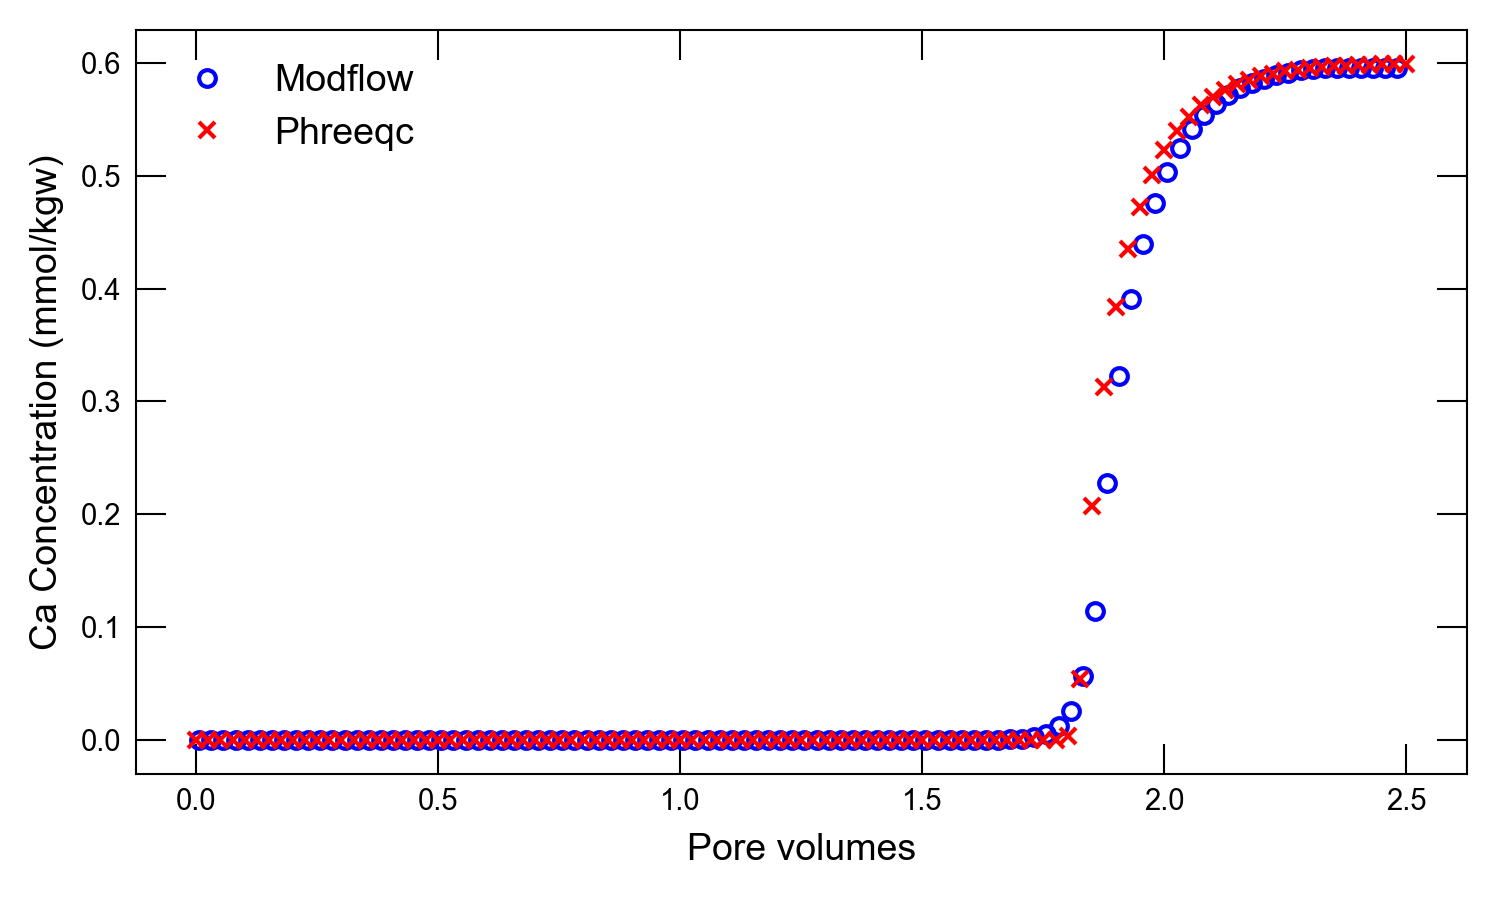

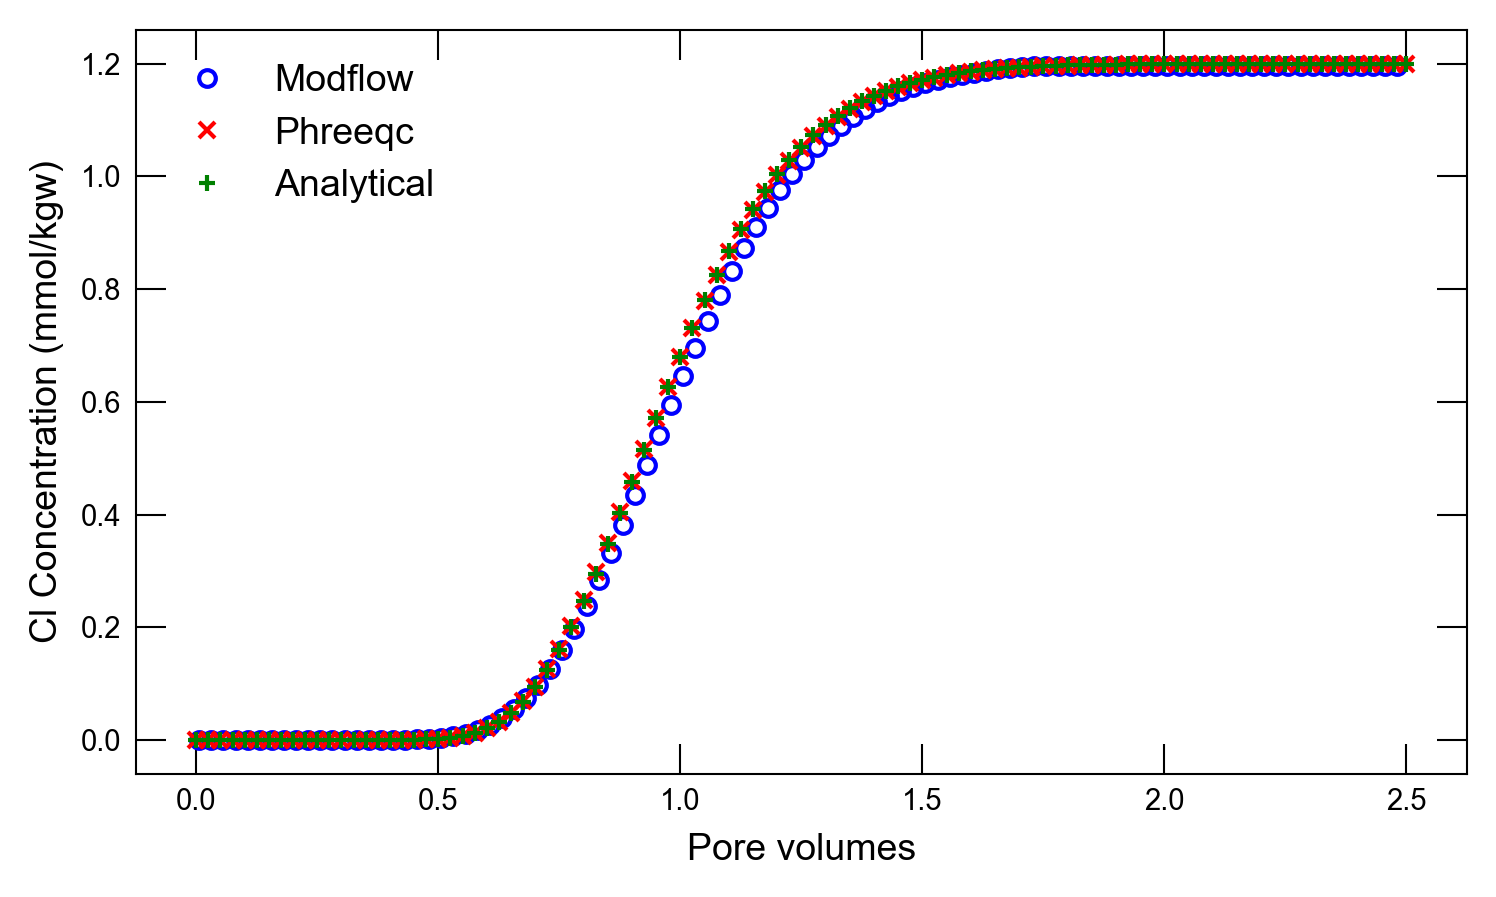

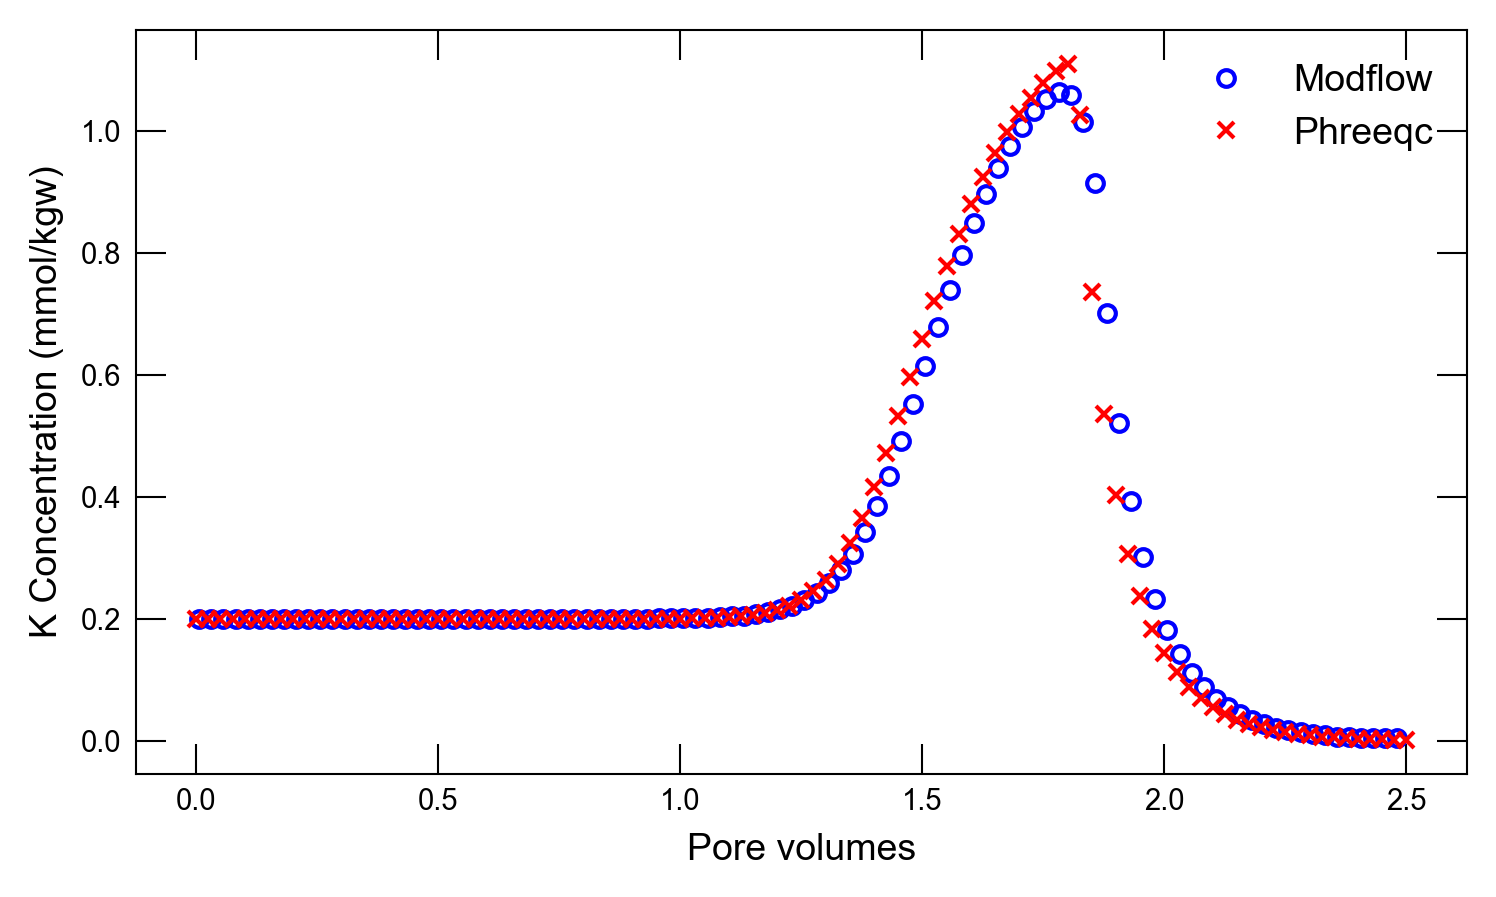

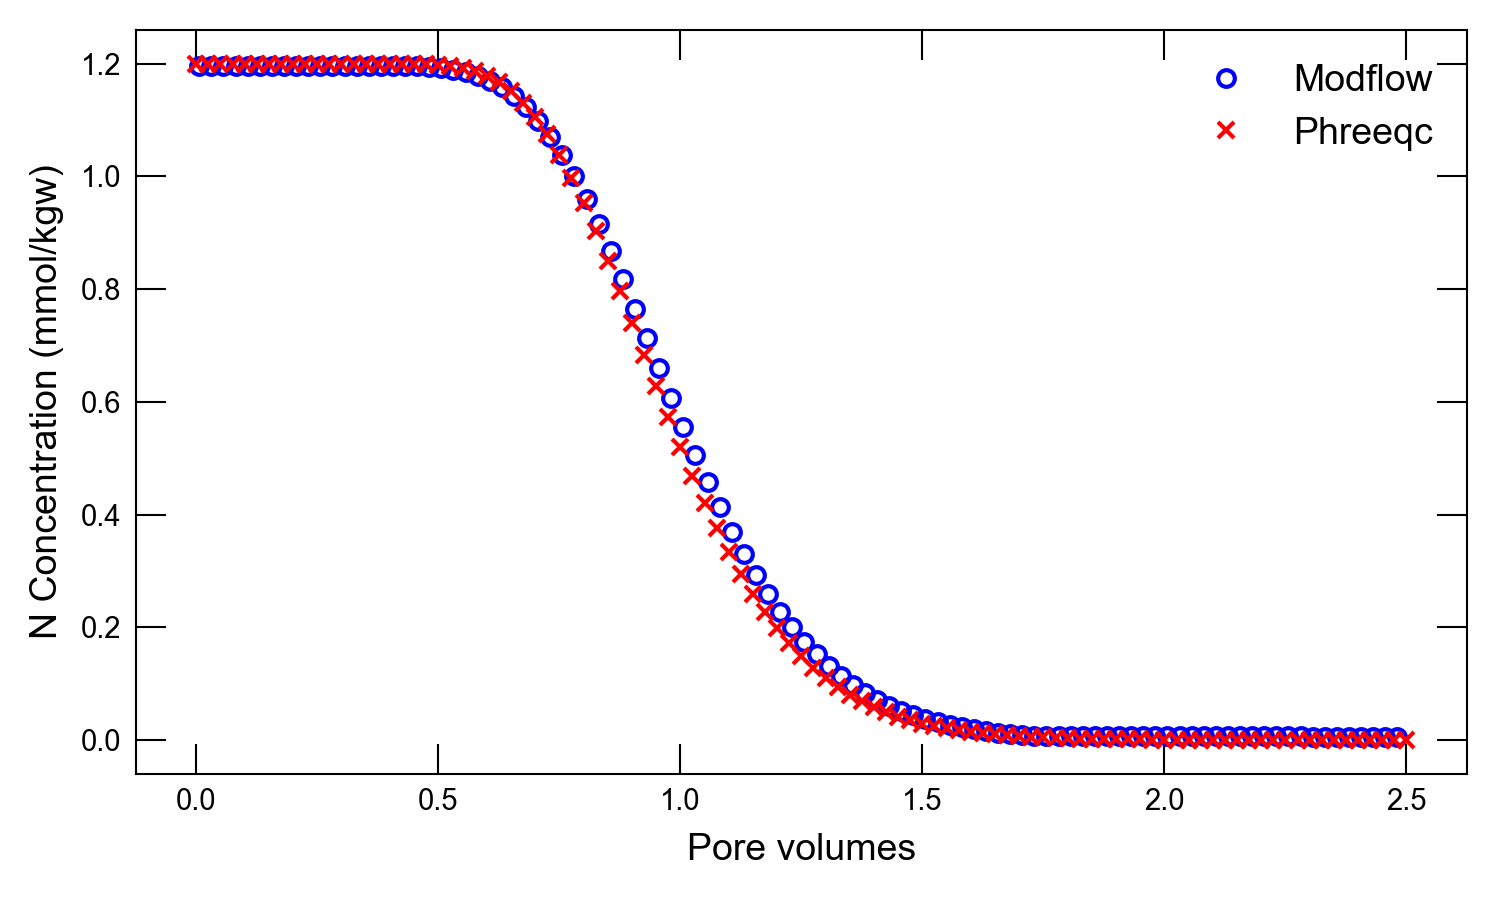

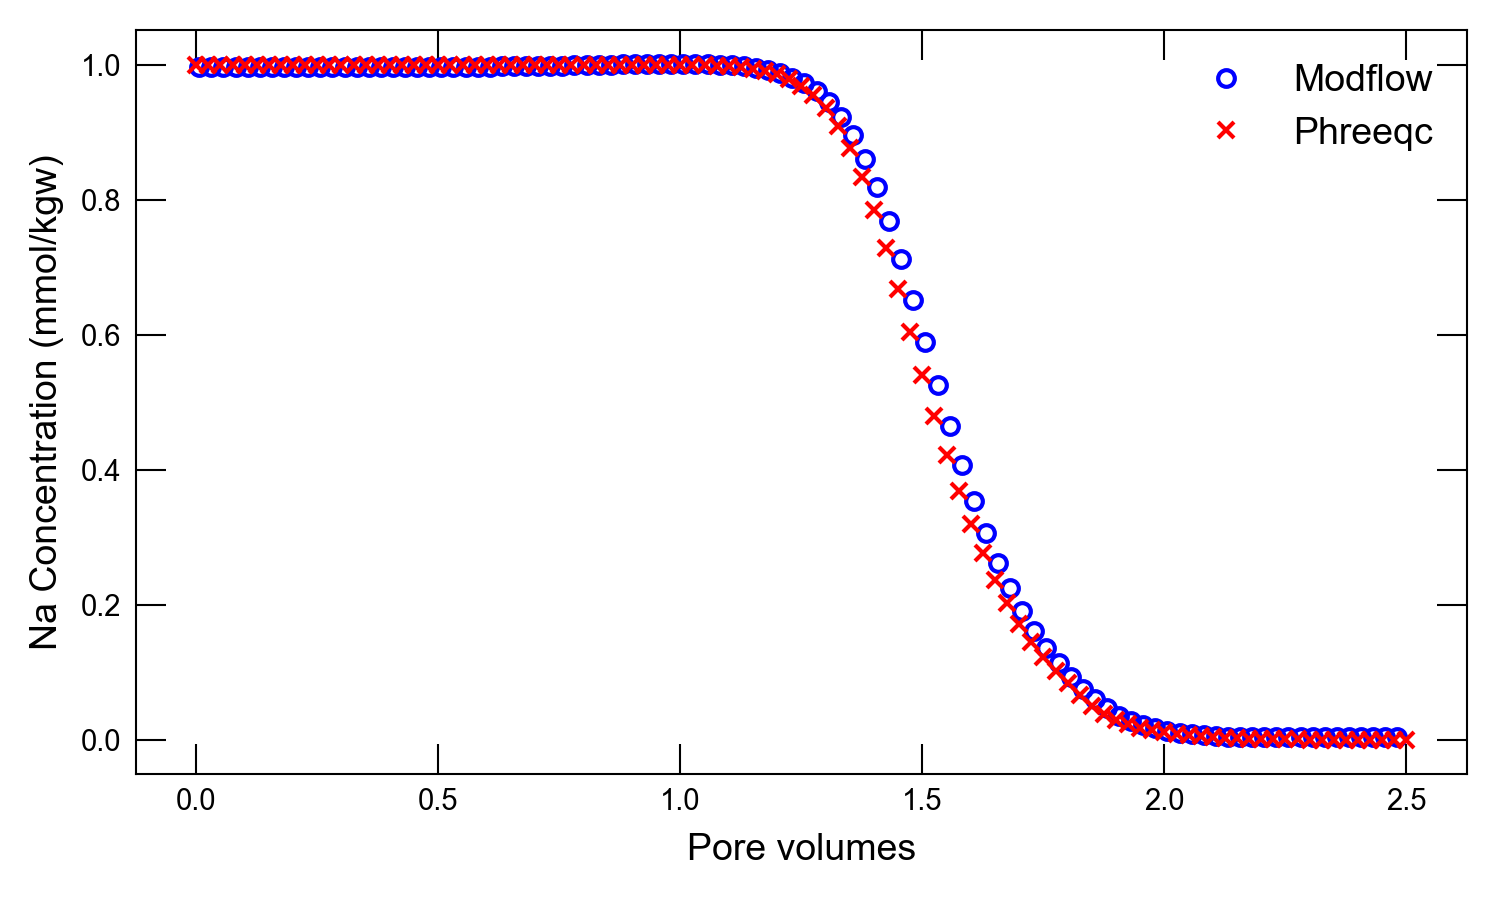

In [26]:
if __name__ == "__main__":
    scenario(0)